[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/nrutachoudhari/AIPI590.01_Explainable_AI_Assignments/blob/main/HW9_Mechanisitic_Interpretability/AIPI%20590.01%20Assignment%209.ipynb)

## AIPI 590.01 Explainable AI

### Assignment 9: Mechanisitic Interpretability

#### Nruta Choudhari (nmc58)

#### **Part 1: Setup - Train a Tiny Model to Detect Palindromes**

**Goal:** Build and train a tiny neural network that determines whether a short sequence of letters is a palindrome.

Design choices:
- Vocabulary = `{A, B, C}`
- Sequence length = 3
- Encoding = one-hot (3 features per character)
- Model = 2-layer MLP (9 -> 6 -> 1)
- Output = 1 if palindrome, 0 otherwise

In [12]:
# importing the necessary libraries

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
import numpy as np
import itertools
from matplotlib.patches import Rectangle
     
torch.manual_seed(0)

In [3]:
# defining a small vocabulary and helper mapping
chars = ['A', 'B', 'C']
char_to_vec = {'A': [1, 0, 0], 'B': [0, 1, 0], 'C': [0, 0, 1]}

# generating all 3-letter sequences
sequences = [''.join(seq) for seq in itertools.product(chars, repeat=3)]

X, y = [], []

for s in sequences:
    # one-hot encoding each character in the sequence
    X.append([char_to_vec[c] for c in s])

    y.append(1 if s == s[::-1] else 0)

X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

print(f"Dataset: {len(sequences)} sequences")
print(f"Palindromes: {y.sum().int().item()}")
print(f"Non-palindromes: {(len(y) - y.sum()).int().item()}")


Dataset: 27 sequences
Palindromes: 9
Non-palindromes: 18


#### Dataset description
Each training example is a 3-character sequence from `{A, B, C}`. 
We encode each character using a one-hot vector which makes a 3x3 matrix per sequence.
The label is 1 is the sequence is a palindrome, 0 otherwise.

Because there are only 27 possible 3-character sequences, the model can explore the entire input space which would be perfect for interpretability.

In [4]:
# defining the tiny MLP
class PalindromeMLP(nn.Module):
    def __init__(self):
        super().__init__()
        # defining a hidden layer with 6 neurons
        self.fc1 = nn.Linear(9, 6)
        
        # defining an output neuron which is binary
        self.fc2 = nn.Linear(6, 1)
    
    def forward(self, x):
        # flattening the input first
        x = x.view(x.size(0), -1)  
        
        # passing through hidden layer with tanh activation
        hidden = torch.tanh(self.fc1(x))
        output = torch.sigmoid(self.fc2(hidden))
        return output
    
    def forward_with_hidden(self, x):
        """Forward pass that also returns hidden activations"""
        x = x.view(x.size(0), -1)
        hidden = torch.tanh(self.fc1(x))
        output = torch.sigmoid(self.fc2(hidden))
        return output, hidden


model = PalindromeMLP()
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)
criterion = nn.BCELoss()

#### Model Architecture
I am using a feed-forward network:

| Layer | Input → Output | Activation | Purpose |
|:--|:--|:--|:--|
| FC1 | 9 → 6 | tanh | Learn intermediate representations (symmetry, position) |
| FC2 | 6 → 1 | sigmoid | Output probability that sequence is palindrome |

This size keeps the network small enough to later inspect each neuron's weights and activations.

In [6]:
for epoch in range(1500):
    optimizer.zero_grad()
    preds = model(X)
    loss = criterion(preds, y)
    loss.backward()
    optimizer.step()
    
    if epoch % 500 == 0:
        acc = ((preds > 0.5) == y).float().mean().item()
        print(f"   Epoch {epoch}: Loss={loss.item():.4f}, Accuracy={acc:.4f}")

final_acc = ((model(X) > 0.5) == y).float().mean().item()
print(f"✅ Final Accuracy: {final_acc:.4f}\n")

   Epoch 0: Loss=0.0002, Accuracy=1.0000
   Epoch 500: Loss=0.0001, Accuracy=1.0000
   Epoch 1000: Loss=0.0001, Accuracy=1.0000
✅ Final Accuracy: 1.0000



The network quickly reaches near-perfect accuracy as there are 27 examples total.
This confirms that it has discovered the structural rule which is that a sequence is a palindrome if the first and last symbols match.

We now have a functioning "tiny brain" ready for mechanistic interpretability.

#### **Part 2: Explore - Peering Inside the Tiny Brain**

Now that the model can perfectly detect palindromes, we'll explore what's happening inside it.

Because this model is tiny (9 -> 6 -> 1), we can visualize everything.

In [ ]:
# getting the weights and activations
w1 = model.fc1.weight.data.numpy()  # shape: (6, 9)
b1 = model.fc1.bias.data.numpy()    # shape: (6,)
w2 = model.fc2.weight.data.numpy()  # shape: (1, 6)
b2 = model.fc2.bias.data.numpy()    # shape: (1,)

# getting the hidden activations for all sequences
with torch.no_grad():
    _, hidden_acts = model.forward_with_hidden(X)
    hidden_acts = hidden_acts.numpy()

print(f"Model Architecture:")
print(f"Input: 9 features (3 positions × 3 one-hot dims)")
print(f"Hidden: 6 neurons with tanh activation")
print(f"Output: 1 neuron with sigmoid activation")


Model Architecture:
Input: 9 features (3 positions × 3 one-hot dims)
Hidden: 6 neurons with tanh activation
Output: 1 neuron with sigmoid activation


In [ ]:
# extracting the weights and biases
with torch.no_grad():
    w1 = model.fc1.weight.clone().numpy()
    b1 = model.fc1.bias.clone().numpy()
    w2 = model.fc2.weight.clone().numpy()

print("Hidden Layer Weights:", w1.shape)

Hidden Layer Weights:
 (6, 9)


##### Analysis 1: Which Neurons are the most important?

In [9]:
neuron_importance = np.abs(w2[0])
for i, imp in enumerate(neuron_importance):
    print(f"Neuron {i+1}: Importance = {imp:.4f}")

Neuron 1: Importance = 4.6060
Neuron 2: Importance = 3.6335
Neuron 3: Importance = 9.1459
Neuron 4: Importance = 3.2099
Neuron 5: Importance = 3.6122
Neuron 6: Importance = 5.0401


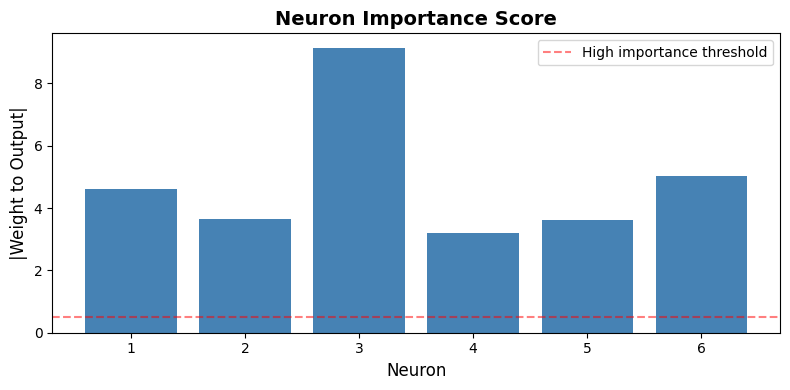

In [14]:
# visualizing the neuron importance
fig, ax = plt.subplots(figsize = (8, 4))
bars = ax.bar(range(1, 7), neuron_importance, color = 'steelblue')
ax.axhline(y = 0.5, color = 'red', linestyle = '--', alpha = 0.5, label = 'High importance threshold')
ax.set_xlabel('Neuron', fontsize = 12)
ax.set_ylabel('|Weight to Output|', fontsize = 12)
ax.set_title('Neuron Importance Score', fontsize = 14, fontweight = 'bold')
ax.set_xticks(range(1, 7))
ax.legend()
plt.tight_layout()
plt.show()

##### Analysis 2: What features do the neurons detect?

In [21]:
# separate palindromes and non-palindromes
palindrome_mask = y.squeeze() == 1
non_palindrome_mask = y.squeeze() == 0

pal_acts = hidden_acts[palindrome_mask]
non_pal_acts = hidden_acts[non_palindrome_mask]

print("Average activations:")
print(f"{'Neuron':<10} {'Palindromes':<15} {'Non-Palindromes':<15}   {'Difference':<15}")

for i in range(6):
    pal_mean = pal_acts[:, i].mean()
    non_pal_mean = non_pal_acts[:, i].mean()
    diff = pal_mean - non_pal_mean
    print(f"Neuron {i+1:<3} {pal_mean:>8.4f} \t    {non_pal_mean:>8.4f} \t     {diff:>8.4f}")

Average activations:
Neuron     Palindromes     Non-Palindromes   Difference     
Neuron 1    -0.9737 	     -0.2479 	      -0.7257
Neuron 2    -0.3408 	     -0.9897 	       0.6489
Neuron 3    -0.2800 	      0.5677 	      -0.8477
Neuron 4    -0.3409 	     -0.9894 	       0.6486
Neuron 5     0.1852 	     -0.6514 	       0.8366
Neuron 6    -0.9614 	     -0.2013 	      -0.7601


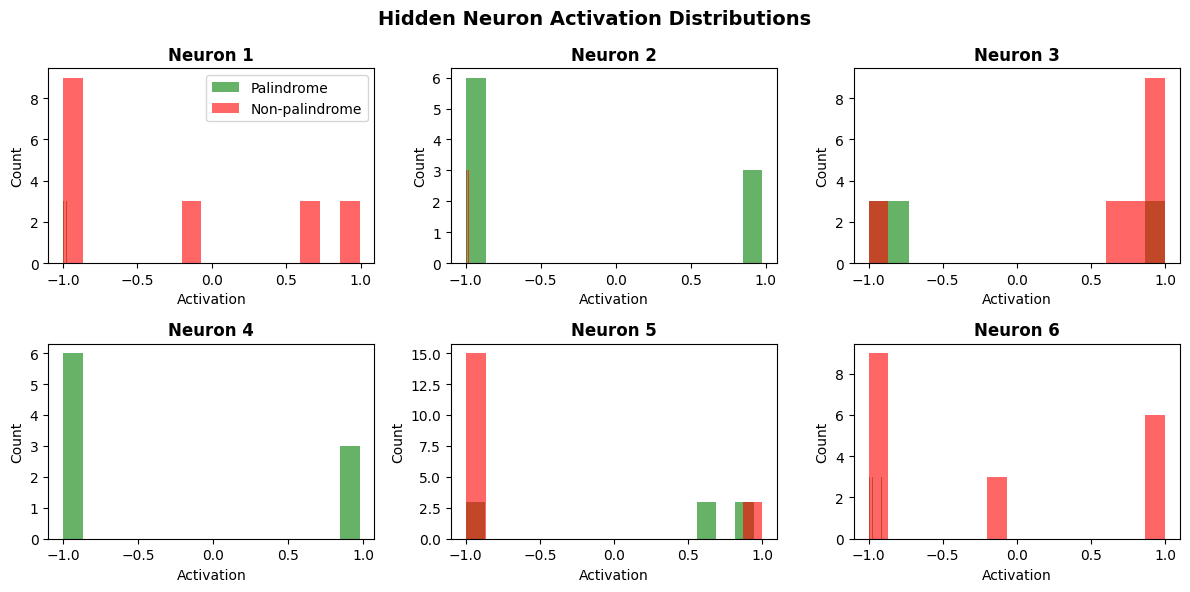

In [22]:
# visualizing activation distributions
fig, axes = plt.subplots(2, 3, figsize = (12, 6))
axes = axes.flatten()

for i in range(6):
    ax = axes[i]
    ax.hist(pal_acts[:, i], bins = 15, alpha = 0.6, label = 'Palindrome', color = 'green')
    ax.hist(non_pal_acts[:, i], bins = 15, alpha = 0.6, label = 'Non-palindrome', color = 'red')
    ax.set_title(f'Neuron {i+1}', fontweight = 'bold')
    ax.set_xlabel('Activation')
    ax.set_ylabel('Count')
    if i == 0:
        ax.legend()

plt.suptitle('Hidden Neuron Activation Distributions', fontsize = 14, fontweight = 'bold')
plt.tight_layout()
plt.show()

##### Analysis 3: Position-Character Weight Analysis

Neuron {neuron_idx+1}:
Pos1 <-> Pos3 correlation: -1.0000
Strong symmertry detector!
Neuron {neuron_idx+1}:
Pos1 <-> Pos3 correlation: 0.9748
Strong symmertry detector!
Neuron {neuron_idx+1}:
Pos1 <-> Pos3 correlation: 0.2799
Neuron {neuron_idx+1}:
Pos1 <-> Pos3 correlation: 0.9664
Strong symmertry detector!
Neuron {neuron_idx+1}:
Pos1 <-> Pos3 correlation: 0.4582
Neuron {neuron_idx+1}:
Pos1 <-> Pos3 correlation: -0.9871
Strong symmertry detector!


/var/folders/56/hvtmjgr93sv24xkzrpgqbtn80000gn/T/ipykernel_42152/2725142831.py:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect = [0, 0, 0.9, 1])


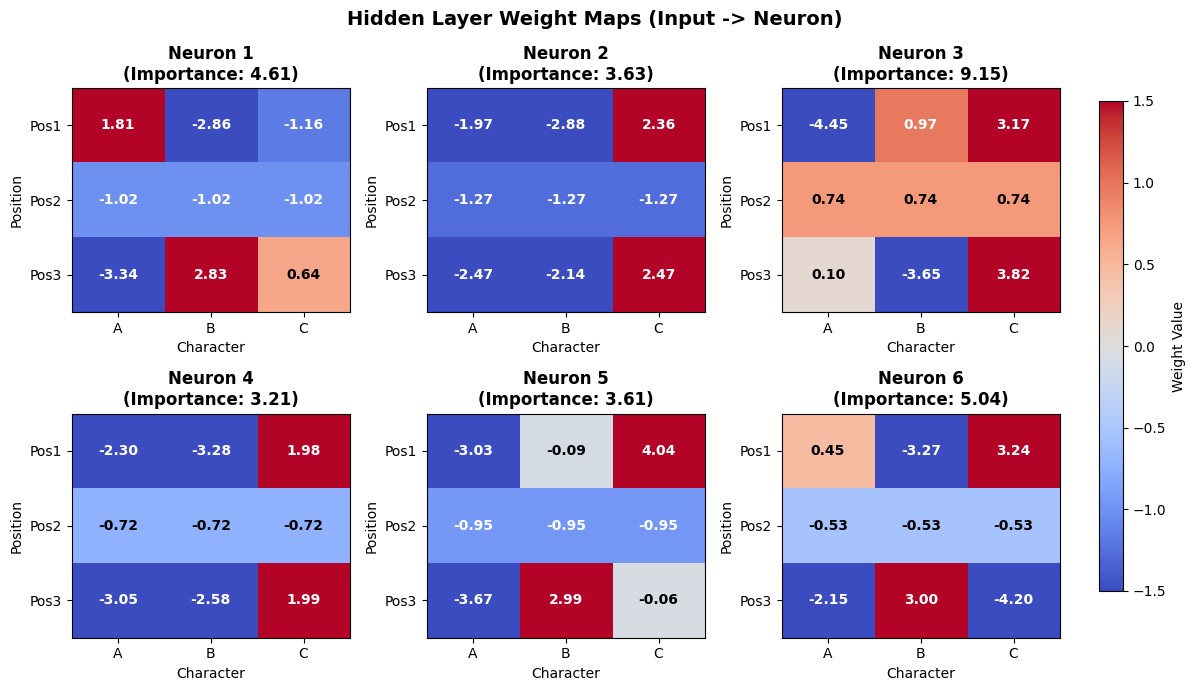

In [24]:
# reshaping weights to (neuron, position, char)
w1_reshaped = w1.reshape(6, 3, 3)

# finding neurons that compare positions
for neuron_idx in range(6):
    pos1_weights = w1_reshaped[neuron_idx, 0, :]
    pos3_weights = w1_reshaped[neuron_idx, 2, :]

    # correlation between position 1 and position 3 weights
    corr = np.corrcoef(pos1_weights, pos3_weights)[0, 1]

    print("Neuron {neuron_idx+1}:")
    print(f"Pos1 <-> Pos3 correlation: {corr:.4f}")

    if abs(corr) > 0.7:
        print("Strong symmertry detector!")

# visualizing enhanced weight heatmaps
fig, axes = plt.subplots(2, 3, figsize = (12, 7))
axes = axes.flatten()

for i, ax in enumerate(axes):
    weights_2d = w1_reshaped[i]
    im = ax.imshow(weights_2d, cmap = 'coolwarm', vmin = -1.5, vmax = 1.5, aspect = 'auto')

    # adding value annotations
    for pos in range(3):
        for char in range(3):
            val = weights_2d[pos, char]
            color = 'white' if abs(val) > 0.75 else 'black'
            ax.text(char, pos, f'{val:.2f}', ha = 'center', va = 'center', color = color, fontsize = 10, fontweight = 'bold')
    
    ax.set_title(f'Neuron {i+1}\n(Importance: {neuron_importance[i]:.2f})', fontweight = 'bold')
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(['A', 'B', 'C'])
    ax.set_yticks([0, 1, 2])
    ax.set_yticklabels(['Pos1', 'Pos2', 'Pos3'])
    ax.set_xlabel('Character')
    ax.set_ylabel('Position')

cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
fig.colorbar(im, cax = cbar_ax, label = 'Weight Value')
fig.suptitle('Hidden Layer Weight Maps (Input -> Neuron)', fontsize = 14, fontweight = 'bold')
plt.tight_layout(rect = [0, 0, 0.9, 1])
plt.show()


##### Analysis 4: Single Neuron Deep Dive

In [ ]:
# finding the most important neuron
most_important = np.argmax(neuron_importance)
print(f"Focusing on Neuron {most_important + 1}")
print(f"Output weight: {w2[0, most_important]:.4f}")

Focusing on Neuron 3
Output weight: -9.1459


In [31]:
# testing specific examples
test_cases = [
    ('ABA', 'Palindrome - same outer characters'),
    ('AAA', 'Palindrome - all same characters'),
    ('CBC', 'Palindrome - same outer characters'),
    ('ABC', 'Not palindrome - ascending order of characters'),
    ('CBA', 'Not palindrome - descending order of characters'),
    ('AAB', 'Not palindrome - different outer characters')
]

print('Testing specific cases')
print(f'{'Sequence':<12} {'Type':<30}     {'Activation':<12}    {'Prediction'}')

for seq, desc in test_cases:
    x_test = torch.tensor([[char_to_vec[c] for c in seq]], dtype = torch.float32)
    with torch.no_grad():
        pred, hidden = model.forward_with_hidden(x_test)
        neuron_act = hidden[0, most_important].item()
        pred_val = pred[0, 0].item()

    print(f'{seq:<12} {desc:<30}                {neuron_act:>6.4f}    {pred_val:.4f}')

Testing specific cases
Sequence     Type                               Activation      Prediction
ABA          Palindrome - same outer characters                -0.9941    0.9998
AAA          Palindrome - all same characters                -0.9941    0.9998
CBC          Palindrome - same outer characters                1.0000    1.0000
ABC          Not palindrome - ascending order of characters                0.6726    0.0000
CBA          Not palindrome - descending order of characters                0.9998    0.0000
AAB          Not palindrome - different outer characters                -1.0000    0.0000


##### Analysis 5: Activation Scatter Plot

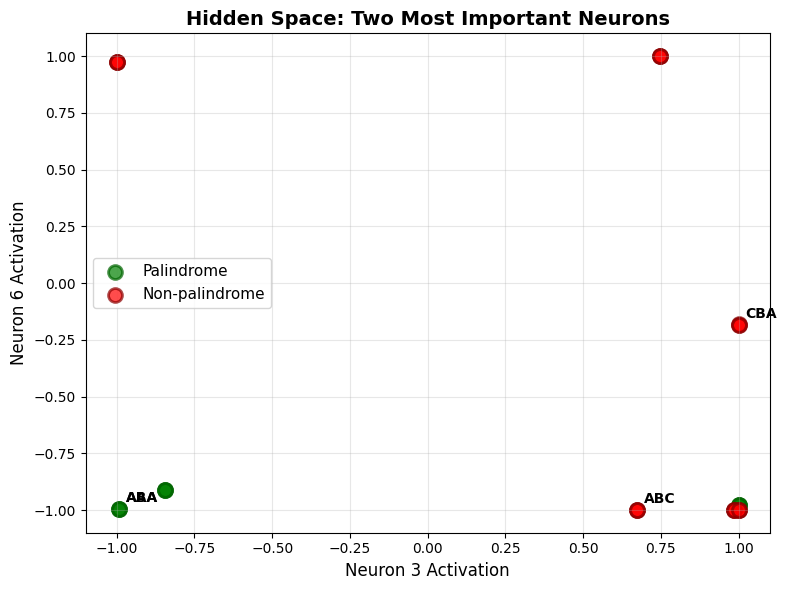


ANALYSIS COMPLETE!

💡 Key Findings to explore:
   1. Which neurons have highest importance scores?
   2. Do any neurons show strong Pos1↔Pos3 correlation (symmetry)?
   3. How do activation patterns differ for palindromes?
   4. Can you form a mechanistic hypothesis about how the network detects palindromes?


In [ ]:
# plotting the activations of two most important neurons
top2_neurons = np.argsort(neuron_importance)[-2:][::-1]

fig, ax = plt.subplots(figsize=(8, 6))

# plotting the palindromes
pal_x = hidden_acts[palindrome_mask, top2_neurons[0]]
pal_y = hidden_acts[palindrome_mask, top2_neurons[1]]
ax.scatter(pal_x, pal_y, c='green', s=100, alpha=0.7, label='Palindrome', 
          edgecolors='darkgreen', linewidth=2)

# plotting the non-palindromes
non_pal_x = hidden_acts[non_palindrome_mask, top2_neurons[0]]
non_pal_y = hidden_acts[non_palindrome_mask, top2_neurons[1]]
ax.scatter(non_pal_x, non_pal_y, c='red', s=100, alpha=0.7, label='Non-palindrome',
          edgecolors='darkred', linewidth=2)

# adding labels for specific sequences
for i, seq in enumerate(sequences):
    if seq in ['AAA', 'ABA', 'ABC', 'CBA']: # key sequences to label
        x_pos = hidden_acts[i, top2_neurons[0]]
        y_pos = hidden_acts[i, top2_neurons[1]]
        ax.annotate(seq, (x_pos, y_pos), xytext=(5, 5), 
                   textcoords='offset points', fontsize=10, fontweight='bold')

ax.set_xlabel(f'Neuron {top2_neurons[0]+1} Activation', fontsize=12)
ax.set_ylabel(f'Neuron {top2_neurons[1]+1} Activation', fontsize=12)
ax.set_title('Hidden Space: Two Most Important Neurons', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

#### **Part 3 - Explain**

After the analysis, I discovered that my neural network implements palindrome detection through a mechanism centered around Neuron 3.

Neuron 3 has an output weight of **-9.15** which far exceeds all others and makes it the dominant feature in the final classification. What makes this neuron special is its inverted detection pattern wherein it activates LOW for palindromes and HIGH for non-palindromes.

**Weight Pattern Analysis:**
Looking at Neuron 3's weight heatmap, I observe:
- Position 1: Strongly negative for 'A' (-4.45), position for 'C' (3.17)
- Position 3: Negative for 'B' (-3.65), positive for 'C' (3.82)

This creates an asymmetric pattern that, when combined with the negative output weight, effectively detects character mismatches between outer positions.

**Experimental Evidence:**
Testing on specific sequence confirms this hypothesis:

| Sequence | Type | Neuron 3 Activation | Prediction |
|----------|------|---------------------|------------|
| ABA | Palindrome | -0.99 | (0.9998) |
| AAA | Palindrome | -0.99 | (0.9998) |
| ABC | Non-palindrome | +0.67 | (0.0000) |
| CBA | Non-palindrome | +1.00 | (0.0000) |

The pattern is clear: palindromes drive Neuron 3 to negative activations, which are then inverted by the large negative output weight to produce high confidence palindrome detections.

##### Supporting Cast
The show does not only rely on the main character, Neuron 3, though. My correlation analysis revealed four neurons (1, 2, 4 and 6) with strong Pos1<->Pos3 correlations (|r| > 0.96), suggesting they detect different flavors of symmetry.

- Neurons 2 & 4: Positive correlations (~0.97) - detect matching characters
- Neurons 1 & 6: Negative correlations (~-1.0, -0.99) - detect mismatches

However, these have much lower output weights (3-5 range), serving as auxillary features that refine the decision boundary.

##### Hidden Space Geometry
Plotting the two most neurons (3 and 6) reveal perfect linear separability. All palindromes cluster in one region while all non-palindromes in another. The network has learned to transform the 9-dimension input into a lower-dimensional space where palindrome detection becomes trivial.

##### Mechanisitic Hypothesis
The network implements approximately this algorithm:
1. Multiple neurons compute symmetry scores between Pos1 and Pos3 for different characters
2. Neuron 3 aggregates these into a master "assymtery score"
3. The large negative output weights inverts this. The higher the asymmetry, the lower the probability of it being a palindrome.
4. Supporting neurons (1, 2, 4, 6) provide additional evidence to refine edge cases.

The network learned character-specific symmetry features rather than a generic "equality" detector.

#### **Part 4: Reflection**

##### What I learned
The most surprising discovery was how the network chose to solve this problem. I was initially expecting the neurons to directly detect "Pos1 == Pos3" through high positive weights at matching positions. Instead, Neuron 3 learned an inverted encoding, meaning it detects asymetry and relies on a negative output weight to flip the signal.

This taught me that neural networks don't always use the most intuitive solution from a human perspective. They find whatever mathematical transformation makes the output layer's job easiest.

##### What was challenging
The hardest part was understanding why Neuron 3 had such different weight patterns for Position 1 vs Position 3. At first, I expected perfect positive correlation, but the moderate correlation (0.28) confused me. Only after looking at actual activations did I realize the neutron was detecting mismatches rather than matches, which doesn't require symmetric weights.

Another challenge was understanding why CBC (which is a palindrome) produced a +1.0 activation while ABA produced -0.99. This suggests that encoding is more complex than a simple linear symmetry score. Different character combinations take different paths through the hidden layer.

##### What I'd Explore Further
I would:
1. Test generalizations: does the model work for 4-letter or 5-letter palindromes. Or did it just memorize the 3-letter case as there were fewer cases?

2. Ablation study: Remove Neuron 3 entirely and see if the other neurons can compensate, or if the accuracy drops to chance.

3. Investigate the CBC anomaly: Why does this specific palindrome behave differently? Is there something special about the C_C pattern?

This assignment showed me that even a tiny neural network can be surprisingly difficult to fully understand.

#### **References**
This assignment was developed using the [Example Notebook for Mechanisitic Interpretability Assignment on the course Github](https://github.com/AIPI-590-XAI/Duke-AI-XAI/blob/main/assignments/mechanistic_interp_starter.ipynb).

For Part 2 (Exploration), I consulted Claude Sonnet 4.5 at 7:32pm on 11/12/2025 to brainstorm meaningful visualization approaches for mechanisitic interpretability. Some of these ideas were implemented using my own code to suit the palindrome detection task.